In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
from os.path import expanduser
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from regression_utils import add_datepart

sns.set();

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
home = expanduser("~")
path2data = home + '/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'

In [4]:
# folder to save figures
path2figures = 'figures/'
if  not os.path.exists(path2figures): os.mkdir(path2figures)

## Download Dataset

In [5]:
if  not os.path.exists(path2data):
    !pip install kaggle
    !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting
    !cd ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting && ls && unzip "*.zip"
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [6]:
!ls {path2data}

air_reserve.csv		date_info.csv		sample_submission.csv
air_reserve.csv.zip	date_info.csv.zip	sample_submission.csv.zip
air_store_info.csv	hpg_reserve.csv		store_id_relation.csv
air_store_info.csv.zip	hpg_reserve.csv.zip	store_id_relation.csv.zip
air_visit_data.csv	hpg_store_info.csv
air_visit_data.csv.zip	hpg_store_info.csv.zip


## Data Loading

In [5]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob( path2data +'*.csv')}
for k, v in dfs.items(): locals()[k] = v

- **air_store_info** contains information about select air restaurants.

- **air_visit_data** contains historical visit data for the air restaurants. It has basicaly the id of the reservation using the air system, visit_date and the number of visitors. In order to combine the provided informations with the new feature we have created a new structure **visitors**. 

- **hpg_store_info** contains information about select hpg restaurants.

- **hpg_reserve** contains informations abourt reservation made using hpg. 

- **air_reserve** contains informations abourt reservation made using air. 

In [6]:
for k,v in  dfs.items(): print(k)

air_store_info
date_info
store_id_relation
hpg_reserve
air_reserve
air_visit_data
sample_submission
hpg_store_info


In [7]:
# Now that we created the local dataframes we don't need the dictionary
del dfs

In [8]:
print('air visit data shape: {}'.format(air_visit_data.shape))
print('sample_submission shape: {}'.format(sample_submission.shape))

air visit data shape: (252108, 3)
sample_submission shape: (32019, 2)


In [9]:
data = air_visit_data.copy()

In [10]:
data['visit_date']= pd.to_datetime(data['visit_date'])
add_datepart(data,'visit_date',drop=False)

data = data.rename(columns={'visit_Dayofweek': 'dow'})
data['visit_date']= data['visit_date'].dt.date

In [11]:
sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission.id.map(lambda x: x.split('_')[2])

sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
add_datepart(sample_submission,'visit_date',drop=False)
sample_submission = sample_submission.rename(columns={'visit_Dayofweek': 'dow'})
sample_submission['visit_date'] = sample_submission['visit_date'].dt.date

#sample_submission = sample_submission.drop('id', axis='columns')

In [12]:
sample_submission.head()

,id,visitors,air_store_id,visit_date,visit_Year,visit_Month,visit_Week,visit_Day,dow,visit_Dayofyear,visit_Is_month_end,visit_Is_month_start,visit_Is_quarter_end,visit_Is_quarter_start,visit_Is_year_end,visit_Is_year_start,visit_Elapsed
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,2017,4,16,23,6,113,False,False,False,False,False,False,1492905600
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,2017,4,17,24,0,114,False,False,False,False,False,False,1492992000
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,2017,4,17,25,1,115,False,False,False,False,False,False,1493078400
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,2017,4,17,26,2,116,False,False,False,False,False,False,1493164800
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,2017,4,17,27,3,117,False,False,False,False,False,False,1493251200


In [13]:
unique_stores = sample_submission['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': 
    [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [14]:
tmp = data.groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

In [15]:
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [16]:
stores = pd.merge(stores, air_store_info, how='left', on=['air_store_id']) 

In [17]:
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


In [18]:
data = pd.merge(data, stores, how='left', on=['air_store_id','dow']) 
sample_submission = pd.merge(sample_submission, stores, how='left', on=['air_store_id','dow'])

One of the big challenges on dataset is the amount of null values from both systems
here it was chose to fill the categorical variables with the most frequent and the continuous values with the median value

In [19]:
for col in ['air_genre_name','air_area_name', 'min_visitors', 'mean_visitors', 
            'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations']:

    if data[col].dtype == 'O':
        data[col].fillna(data[col].value_counts().index[0],inplace=True)  
        sample_submission[col].fillna(sample_submission[col].value_counts().index[0],inplace=True)
    else:
        data[col].fillna(data[col].median(),inplace=True)  
        sample_submission[col].fillna(sample_submission[col].median(),inplace=True)


Also the latitude and longitude were carefully analyzed to fill the nan values with the same coordination of the area name of the restaurant

In [20]:
loc = data[(data['longitude'].isnull())|
           (data['latitude'].isnull())].air_area_name.unique().tolist()
loc

['Fukuoka-ken Fukuoka-shi Daimyō']

In [21]:
coords = ['latitude','longitude']
data[coords].isnull().sum()

latitude     1640
longitude    1640
dtype: int64

In [22]:
for coord in coords:
    mf_val = data[data['air_area_name']==loc[0]][coord].mode()[0]
    data[coord].fillna(mf_val,inplace=True)  
data[coords].isnull().sum()

latitude     0
longitude    0
dtype: int64

In [23]:
data.isnull().sum()

air_store_id              0
visit_date                0
visitors                  0
visit_Year                0
visit_Month               0
visit_Week                0
visit_Day                 0
dow                       0
visit_Dayofyear           0
visit_Is_month_end        0
visit_Is_month_start      0
visit_Is_quarter_end      0
visit_Is_quarter_start    0
visit_Is_year_end         0
visit_Is_year_start       0
visit_Elapsed             0
min_visitors              0
mean_visitors             0
median_visitors           0
max_visitors              0
count_observations        0
air_genre_name            0
air_area_name             0
latitude                  0
longitude                 0
dtype: int64

In [24]:
date_info = date_info.rename(columns={'calendar_date':'visit_date'})
date_info['visit_date'] = pd.to_datetime(date_info['visit_date']).dt.date

In [25]:
date_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [26]:
data = data.merge(date_info, on='visit_date', how='left')

In [27]:
data.isnull().sum().sum()

0

In [28]:
sample_submission = sample_submission.merge(date_info, on='visit_date', how='left')
sample_submission.isnull().sum().sum()

0

In [29]:
print('Features shape: {}'.format(data.shape))

Features shape: (252108, 27)


The number of visitor which is the target of the problem was transformed used a **log(1 + visitors)**. This transformation brings the distribution of visitors closer to a gaussian distribution which helps convergence and the final metric of the competition is RMSLE which can be converted to RMSE by transforming the target

In [30]:
data['visitors_log'] = data.visitors.map(pd.np.log1p)
sample_submission['visitors_log'] = sample_submission.visitors.map(pd.np.log1p)

In [31]:
data.head()

,air_store_id,visit_date,visitors,visit_Year,visit_Month,visit_Week,visit_Day,dow,visit_Dayofyear,visit_Is_month_end,...,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,visitors_log
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,2,13,2,13,False,...,25.0,57.0,64.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,3.258097
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,2,14,3,14,False,...,21.0,54.0,65.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Thursday,0,3.496508
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,2,15,4,15,False,...,35.0,61.0,65.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,0,3.401197
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,2,16,5,16,False,...,27.0,53.0,66.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Saturday,0,3.135494
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,3,18,0,18,False,...,12.0,34.0,57.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Monday,0,1.945910


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


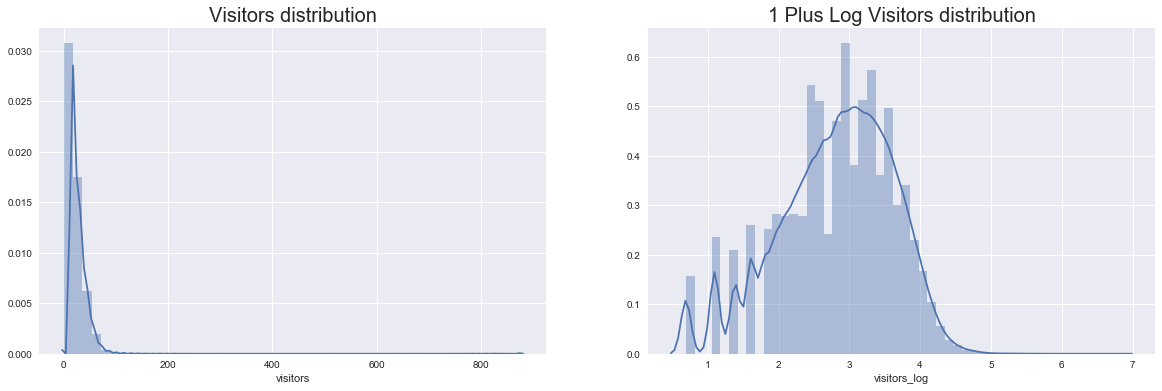

In [32]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(data['visitors'])
plt.title('Visitors distribution', fontsize=20)
plt.subplot(1,2,2)
sns.distplot(data['visitors_log'])
plt.title('1 Plus Log Visitors distribution', fontsize=20)

fig.savefig(path2figures + 'visitor_distribution.png')

In [33]:
data[['visitors', 'visitors_log']].describe()

,visitors,visitors_log
count,252108.000000,252108.000000
mean,20.973761,2.802788
std,16.757007,0.807726
min,1.000000,0.693147
25%,9.000000,2.302585
50%,17.000000,2.890372
75%,29.000000,3.401197
max,877.000000,6.777647


In [34]:
data.isnull().sum().sum()

0

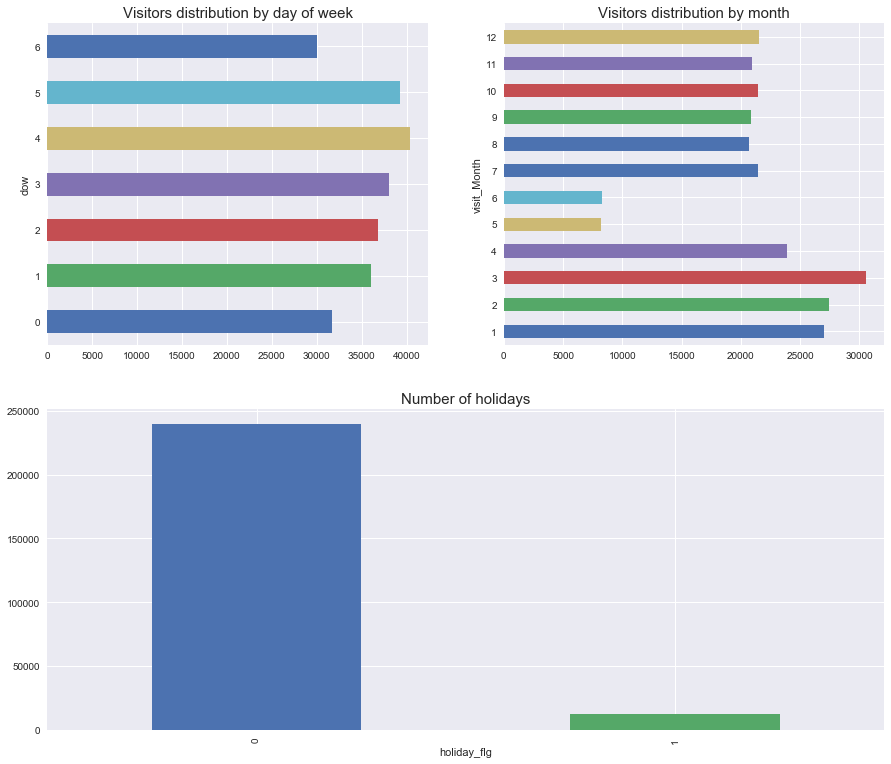

In [35]:
fig = plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
plt.title('Visitors distribution by day of week', fontsize=15)
data.groupby('dow')['visitors'].count().plot(kind = 'barh')

plt.subplot(2,2,2)
plt.title('Visitors distribution by month', fontsize=15)
data.groupby('visit_Month')['visitors'].count().plot(kind = 'barh')

plt.subplot(2,2,(3,4))
plt.title('Number of holidays', fontsize=15)
data.groupby('holiday_flg').size().plot(kind = 'bar')

fig.savefig(path2figures + 'visitor_distribution_period.png')

### Extract informations about the spatial location of the restaurant
    - Todofuken
    - city
    - street

In [36]:
def get_spatial_information(data):

    area  = data.air_area_name.str.split(' ', expand=True)

    data['Todofuken'] = area[0]
    data['city'] = area[1]
    data['street'] = area.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna()), axis=1)
    
    return data

In [37]:
data = get_spatial_information(data)
sample_submission = get_spatial_information(sample_submission)

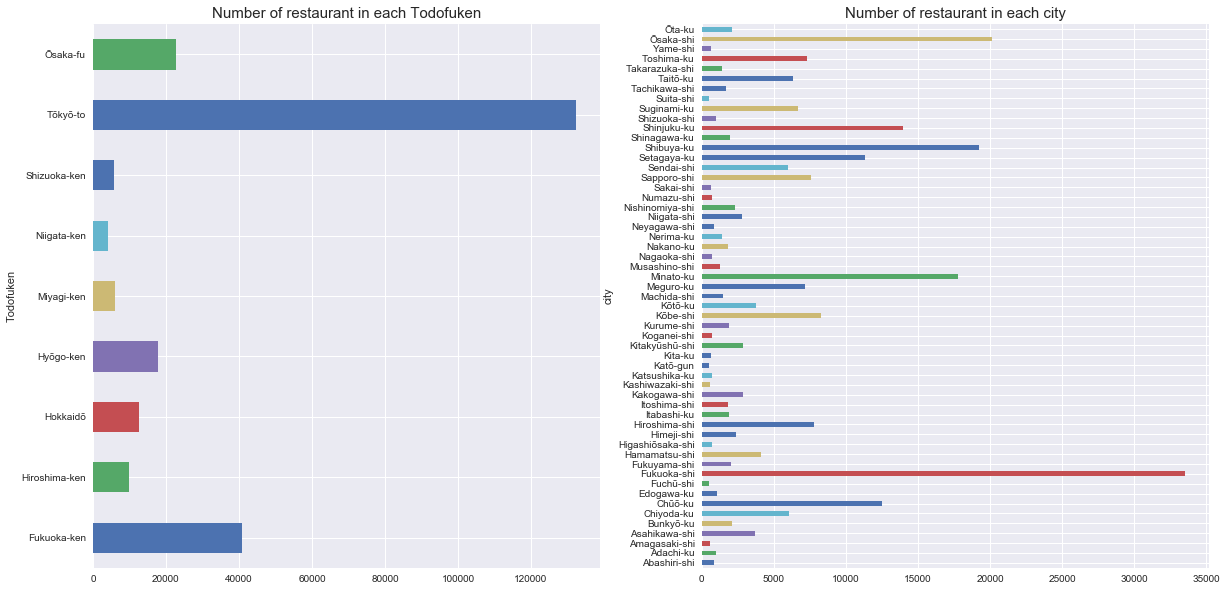

In [38]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
data.groupby(['Todofuken']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each Todofuken', fontsize=15)

plt.subplot(1,2,2)
data.groupby(['city']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each city', fontsize=15)
          
fig.savefig(path2figures + 'stores_distribution.png')

In [39]:
data.isnull().sum().sum()

0

### Weather informations

In order to create a more robust model, we have used information about the [weather](https://www.kaggle.com/huntermcgushion/rrv-weather-data). The cell bellow will download automatically this dataset. To add the precipitation and avg_temperature it will be used the function [add_weather](https://gist.github.com/superMDguy/72689a11746079677ddb0d19f26443a1) as demonstrated bellow.

In [38]:
def add_weather(dataset, path2weather='raw/weather/'):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        path2weather + 'air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = dataset.air_store_id.unique().tolist()                                                                                
                                                                                                                                              
    weather_dir = path2weather + '1-1-16_5-31-17_Weather/'                                                                            
    weather_keep_columns = ['precipitation', 'avg_temperature']                                                                                                                         
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan                                                                                                 
                                                                                                                                              
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]                                                          
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                           
                                                                                                                                              
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
                                                                                                                                              
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]                                                                     
    return dataset_with_weather   

In [39]:
analyze_weather = False

if analyze_weather:
    path2weather = 'raw/weather/'

    if  not os.path.exists(path2weather):
        !wget -O rrv-weather-data.zip "https://storage.googleapis.com/kaggle-datasets/7480/12096/rrv-weather-data.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528816610&Signature=kDnX2dX3Pd8VGbR6rqRmDH7XYFjBiKYnz3hoez3AWjv0oUf2vJKLpYKV7zfLb%2FgNJE2kXy9D8%2BNvmNkx4LrJHRvVrIMsGyMe%2FM0x1Z3Kxk6nJMSI9BDZGhsyBSONBKPNdND%2FEHuo2k1T2Wo8tOBu1VOOQlLt8NkblTCBx3ihEvEapCq6UgtfNvYvnE55MI8TBCNLcMBBBUU3Cv251yywybyUTAGRfWfIoc2hcYkrVV0j8EtOCfX5CKrAmvxhnuzLBKvlapIrYmOLRtwjlyFfQh2nWqpQGb7ORj%2BUfTvL3trMgOd06aozbCj4A207p%2FBd2IBEweYElxsgddGdpwaLHg%3D%3D"
        !mkdir -p raw/weather/
        !mv rrv-weather-data.zip raw/weather/
        !cd raw/weather/ && unzip rrv-weather-data.zip
        !cd raw/weather/ && unzip 1-1-16_5-31-17_Weather.zip
    else:
        print('Weather Dataset already downloaded!')

    print('Dataset shape: {}'.format(data.shape))
    data = add_weather(data)


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 31 columns):
air_store_id              252108 non-null object
visit_date                252108 non-null object
visitors                  252108 non-null int64
visit_Year                252108 non-null int64
visit_Month               252108 non-null int64
visit_Week                252108 non-null int64
visit_Day                 252108 non-null int64
dow                       252108 non-null int64
visit_Dayofyear           252108 non-null int64
visit_Is_month_end        252108 non-null bool
visit_Is_month_start      252108 non-null bool
visit_Is_quarter_end      252108 non-null bool
visit_Is_quarter_start    252108 non-null bool
visit_Is_year_end         252108 non-null bool
visit_Is_year_start       252108 non-null bool
visit_Elapsed             252108 non-null int64
min_visitors              252108 non-null float64
mean_visitors             252108 non-null float64
median_visitors          

## Reservation

In [40]:
air_reserve.shape, hpg_reserve.shape

((92378, 4), (2000320, 4))

**store_id_relation** has the relationship between the two separate sites in which the data comes:
    
Hot Pepper Gourmet (**hpg**): similar to Yelp, here users can search restaurants and also make a reservation online

AirREGI / Restaurant Board (**air**): similar to Square, a reservation control and cash register system

In [41]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [42]:
hpg_reserve = pd.merge(hpg_reserve, store_id_relation, how='inner', on=['hpg_store_id'])

In [43]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


In [44]:
for df in [air_reserve, hpg_reserve]:

    df['visit_datetime'] = pd.to_datetime(df.visit_datetime).dt.date
    df['reserve_datetime'] = pd.to_datetime(df.reserve_datetime).dt.date

    df['reserve_ahead'] =  df['visit_datetime']- df['reserve_datetime']
    df['reserve_ahead_days'] = df['reserve_ahead'].dt.days
    
    df = df.groupby(['air_store_id','visit_datetime'], as_index=False)[[
        'reserve_ahead_days', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})
    
    
    data = pd.merge(data, df, how='left', on=['air_store_id','visit_date']) 
    sample_submission = pd.merge(sample_submission, df, how='left', on=['air_store_id','visit_date']) 

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 35 columns):
air_store_id              252108 non-null object
visit_date                252108 non-null object
visitors                  252108 non-null int64
visit_Year                252108 non-null int64
visit_Month               252108 non-null int64
visit_Week                252108 non-null int64
visit_Day                 252108 non-null int64
dow                       252108 non-null int64
visit_Dayofyear           252108 non-null int64
visit_Is_month_end        252108 non-null bool
visit_Is_month_start      252108 non-null bool
visit_Is_quarter_end      252108 non-null bool
visit_Is_quarter_start    252108 non-null bool
visit_Is_year_end         252108 non-null bool
visit_Is_year_start       252108 non-null bool
visit_Elapsed             252108 non-null int64
min_visitors              252108 non-null float64
mean_visitors             252108 non-null float64
median_visitors          

In [46]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 36 columns):
id                        32019 non-null object
visitors                  32019 non-null int64
air_store_id              32019 non-null object
visit_date                32019 non-null object
visit_Year                32019 non-null int64
visit_Month               32019 non-null int64
visit_Week                32019 non-null int64
visit_Day                 32019 non-null int64
dow                       32019 non-null int64
visit_Dayofyear           32019 non-null int64
visit_Is_month_end        32019 non-null bool
visit_Is_month_start      32019 non-null bool
visit_Is_quarter_end      32019 non-null bool
visit_Is_quarter_start    32019 non-null bool
visit_Is_year_end         32019 non-null bool
visit_Is_year_start       32019 non-null bool
visit_Elapsed             32019 non-null int64
min_visitors              32019 non-null float64
mean_visitors             32019 non-null float

In [47]:
# Define a best way to replace missing values

data = data.fillna(-1) 
sample_submission = sample_submission.fillna(-1)

### Drop features

In [48]:
redundant_col = ['air_area_name', 'air_store_id', 'day_of_week']

drop_col = [ 'visit_date', 'visitors']

In [49]:
data = data.drop(redundant_col+ drop_col, axis='columns')
sample_submission = sample_submission.drop(redundant_col+ drop_col, axis='columns')

In [50]:
print('Features shape: {}'.format(data.shape))

Features shape: (252108, 30)


In [51]:
print('Atributs of the data: {}'.format(data.keys().values))

Atributs of the data: ['visit_Year' 'visit_Month' 'visit_Week' 'visit_Day' 'dow'
 'visit_Dayofyear' 'visit_Is_month_end' 'visit_Is_month_start'
 'visit_Is_quarter_end' 'visit_Is_quarter_start' 'visit_Is_year_end'
 'visit_Is_year_start' 'visit_Elapsed' 'min_visitors' 'mean_visitors'
 'median_visitors' 'max_visitors' 'count_observations' 'air_genre_name'
 'latitude' 'longitude' 'holiday_flg' 'visitors_log' 'Todofuken' 'city'
 'street' 'reserve_ahead_days_x' 'reserve_visitors_x'
 'reserve_ahead_days_y' 'reserve_visitors_y']


**Target**:
- visitors_log;

**Inputs**
- test_set;
- air_genre_name;
- latitude;
- longitude;
- hpg_genre_name;
- holiday_flg;
- weight;
- station_id;
- precipitation;
- avg_temperature;
- Todofuken;
- city;
- street;
- reserve_visitors;
- reserve_ahead_seconds;
- Related to the visit date: 
    - visit_Year;
    - visit_Month;
    - visit_Week;
    - visit_Day;
    - visit_Dayofweek;
    - visit_Dayofyear;
    - visit_Is_month_end;
    - visit_Is_month_start;
    - visit_Is_quarter_end;
    - visit_Is_quarter_start;
    - visit_Is_year_end;
    - visit_Is_year_start;
    - visit_Elapsed;



## LabelEncoder encondig

Encode categorical features: **Todofuken**, **city**, **street**, **air_genre_name**, **hpg_genre_name**.

In [52]:
from sklearn.preprocessing import LabelEncoder

dummies_col = ['Todofuken', 'street', 'city', 'air_genre_name']

for column in dummies_col:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column]).tolist()
    sample_submission[column] = le.fit_transform(sample_submission[column]).tolist()

In [53]:
print('Features shape: {}'.format(data.shape))

Features shape: (252108, 30)


## Split data in train, valid and test set

In [54]:
val_size = 0.2

In [55]:
def split_by_factor(data, val_size=0.2):
    split= 1 - val_size
    tr,val = np.split(data,[int(len(data)*split)])    
    return tr,val 

In [56]:
train, valid = split_by_factor(data)
test = sample_submission.copy()

In [57]:
print('Train set shape: {}'.format(train.shape))
print('Valid set shape: {}'.format(valid.shape))
print('Test set shape: {}'.format(test.shape))

Train set shape: (201686, 30)
Valid set shape: (50422, 30)
Test set shape: (32019, 34)


In [110]:
predictors = [x for x in train.columns if x not in ['visitors_log'] ]

target = 'visitors_log'

# Features Analysis

In [61]:
train[predictors].isnull().sum().sum()

0

In [67]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=40, min_samples_leaf=10, max_features='sqrt',
                             n_jobs=-1, oob_score=True,random_state=0)

In [68]:
reg.fit(train[predictors],train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [69]:
from regression_utils import print_score
print_score(reg,train[predictors],train[target],valid[predictors],valid[target])

 Train Score:
RMSE: 0.443451, MAE: 0.325365
Oob score : 0.623694
------------------------------
 Val Score:
RMSE: 0.501601, MAE: 0.373005


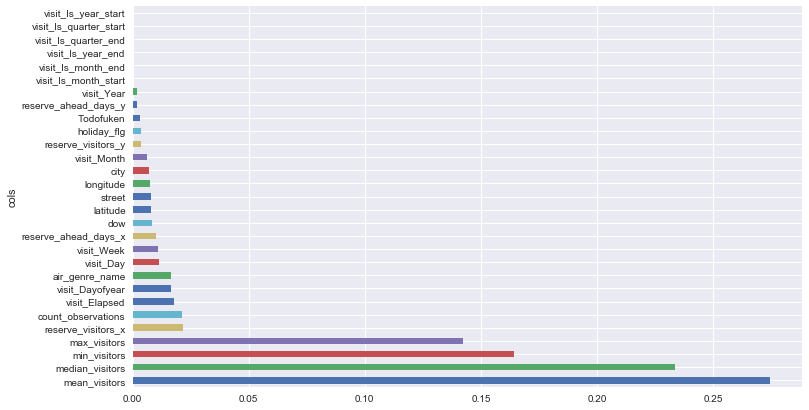

In [70]:
from regression_utils import rf_feat_importance,plot_fi

fi = rf_feat_importance(reg, train[predictors])
plot_fi(fi[:40]);

In [71]:
to_keep = fi[fi.imp>1e-2].cols.tolist(); len(to_keep),len(predictors)

(11, 29)

In [72]:
reg.fit(train[to_keep],train[target])
print_score(reg,train[to_keep],train[target],valid[to_keep],valid[target])

 Train Score:
RMSE: 0.442236, MAE: 0.323929
Oob score : 0.615624
------------------------------
 Val Score:
RMSE: 0.502698, MAE: 0.372501


In [67]:
# The results of RMSE and Oob score didn't change much droping the 8 features using the threshold of
# feature importances, let's try one more time 

In [73]:
predictors = to_keep.copy()

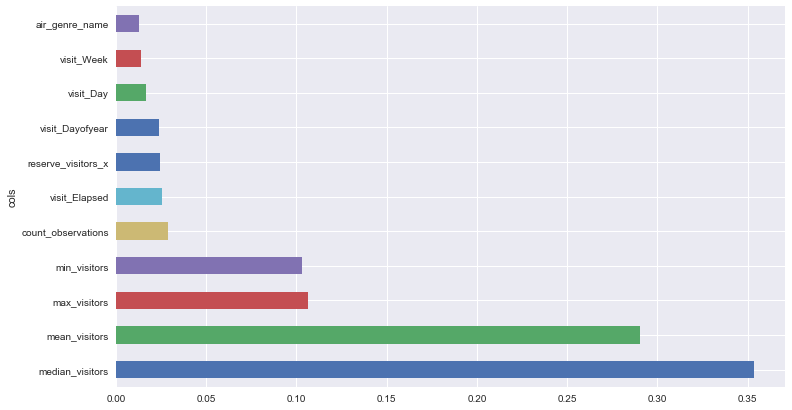

In [74]:
fi = rf_feat_importance(reg, train[predictors])
plot_fi(fi[:40]);

In [75]:
to_keep = fi[fi.imp>2e-2].cols.tolist(); len(to_keep),len(predictors)

(8, 11)

In [76]:
reg.fit(train[to_keep],train[target])
print_score(reg,train[to_keep],train[target],valid[to_keep],valid[target])

 Train Score:
RMSE: 0.453866, MAE: 0.332548
Oob score : 0.616213
------------------------------
 Val Score:
RMSE: 0.504008, MAE: 0.374289


# Predictive modelling

## Decision Trees

### XGBoost

Since XGBoost already does feature selection using gamma, we could also try using whole set of features 
and optimize gamma for that

In [131]:
from regression_utils import cross_valid
import xgboost as xgb

def xgbCV(gamma,reg_lambda,
          min_child_weight,
          colsample_bytree,subsample):

    reg = xgb.sklearn.XGBRegressor(gamma=max(gamma, 0),
                                    max_depth= 4,
                                    min_child_weight= int(min_child_weight),
                                    subsample = max(min(subsample, 1), 0),
                                    colsample_bytree= max(min(colsample_bytree, 1), 0),
                                    reg_lambda= max(reg_lambda, 0), 
                                    n_estimators=100,
                                    n_jobs=5)

    score = cross_valid(reg,train[predictors +[target]].values,folds=5,
                        metric='rmse',verbose=False)

    res = np.mean(score)/(1+np.std(score)) # 1/std -> For reducing the variance between folds 
    return -res  # Negative because we want to minimize score and BayesianOptimization only maximize scores

In [112]:
from bayes_opt import BayesianOptimization
#https://github.com/fmfn/BayesianOptimization

In [132]:
gp_params = {"alpha": 1e-5,"n_restarts_optimizer": 2}

xgbBO = BayesianOptimization(xgbCV, {'min_child_weight': (1, 60),
                                     'subsample': (0.8, 1),
                                     'colsample_bytree': (0.8, 1),
                                     'gamma': (0, 10),
                                     'reg_lambda': (1, 10),
                                    })

In [133]:
xgbBO.maximize(init_points=4,n_iter=24, acq="ei", xi=1e-2, **gp_params)

Initialization
----------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   min_child_weight |   reg_lambda |   subsample | 
    1 | 00m46s |   -0.49977 |             0.9420 |    7.7246 |            25.8240 |       7.5556 |      0.9117 | 
    2 | 00m45s |   -0.49981 |             0.8214 |    5.9805 |            53.7940 |       5.3471 |      0.8631 | 
    3 | 00m50s |   -0.49922 |             0.9607 |    3.1394 |             7.7569 |       2.6055 |      0.9411 | 
    4 | 00m50s |   -0.49967 |             0.8244 |    4.7967 |            50.9114 |       5.6014 |      0.8704 | 
Bayesian Optimization
----------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   min_child_weight |   reg_lambda |   subsample | 
    5 | 00m49s |   -0.49912 |             0.9132 |   

In [134]:
xgbBO.res['max']['max_val']

-0.4990156037559958

In [135]:
paramsBO = xgbBO.res['max']['max_params']
paramsBO

{'min_child_weight': 1.0159109048482697,
 'subsample': 0.9548980144031659,
 'colsample_bytree': 0.9795064688876627,
 'gamma': 0.10577233216894522,
 'reg_lambda': 1.5453136664172031}

In [136]:
reg = xgb.sklearn.XGBRegressor(gamma=max(paramsBO['gamma'], 0),
                                max_depth= 4,
                                min_child_weight= int(paramsBO['min_child_weight']),
                                subsample =  max(min(paramsBO['subsample'], 1), 0),#1,
                                colsample_bytree= max(min(paramsBO['colsample_bytree'], 1), 0),
                                reg_lambda= max(paramsBO['reg_lambda'], 0),
                                n_jobs=7, 
                                n_estimators=200) # Get some more trees

reg.fit(train[predictors],train[target]) # Fit best Model on whole train data 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9795064688876627, gamma=0.10577233216894522,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=7,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1.5453136664172031, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9548980144031659)

In [137]:
ypred = reg.predict(train[predictors])
ytrue= train[target].values

ytrue.shape,ypred.shape

((201686,), (201686,))

In [138]:
from sklearn.metrics import mean_absolute_error as mae
from regression_utils import rmse

mae(ytrue,ypred),rmse(ytrue,ypred)

(0.3664308039492667, 0.497132766871083)

In [139]:
ypred = reg.predict(valid[predictors])
ytrue= valid[target].values

ytrue.shape,ypred.shape

((50422,), (50422,))

In [140]:
mae(ytrue,ypred),rmse(ytrue,ypred)

(0.3680277836956653, 0.4970890368259036)

In [141]:
import copy
Best_xgb = copy.copy(reg)
Best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9795064688876627, gamma=0.10577233216894522,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=7,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1.5453136664172031, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9548980144031659)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


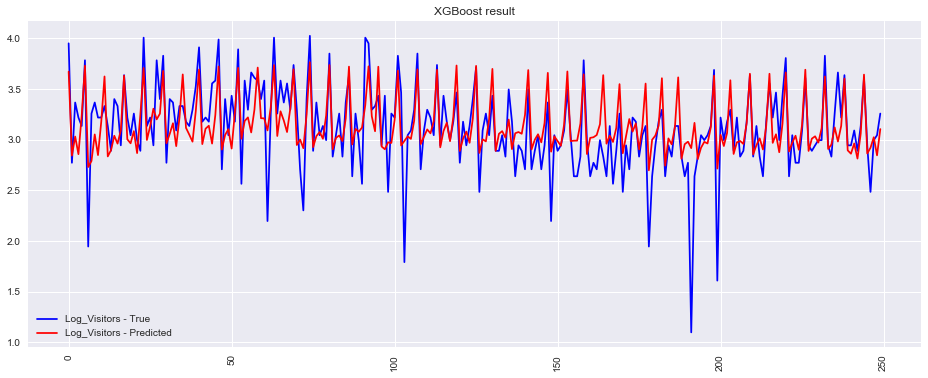

In [101]:
n_samples = 250
fig = plt.figure(figsize=(16,6))     

plt.plot(ytrue[:n_samples], c = 'blue',label='Log_Visitors - True')

plt.plot(ypred[:n_samples], c = 'red', label='Log_Visitors - Predicted')


plt.xticks(rotation=90)
#plt.xscale('log')
plt.title('XGBoost result')
plt.xlabel('')
plt.ylabel('')
#plt.ylim([-25e-6,25e-6])
plt.grid('on')
plt.legend()
plt.show()

### LGB

In [88]:
import lightgbm as lgb
def lgbmCV(min_child_weight,
          colsample_bytree,
          subsample):

    reg = lgb.LGBMRegressor(min_child_weight=max(min_child_weight, 0),
                             max_depth= 4,
                             subsample = max(min(subsample, 1), 0),
                             colsample_bytree= max(min(colsample_bytree, 1), 0),
#                             reg_lambda= max(reg_lambda, 0), 
                             n_estimators=100,
                             n_jobs=7)

    score = cross_valid(reg,train[predictors +[target]].values,folds=5,
                        metric='rmse',verbose=False)

    res = np.mean(score)/(1+np.std(score)) 
    return -res  

In [106]:
gp_params = {"alpha": 1e-5,"n_restarts_optimizer": 2}

lgbBO = BayesianOptimization(lgbmCV, {'min_child_weight': (1, 60),
                                     'subsample': (0.8, 1),
                                     'colsample_bytree': (0.8, 1),
#                                     'reg_lambda': (1, 10),
                                    })

In [107]:
lgbBO.maximize(init_points=4,n_iter=24, acq="ei", xi=1e-2, **gp_params)

Initialization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   min_child_weight |   subsample | 
    1 | 00m12s |   -0.49918 |             0.5886 |            15.9409 |      0.9896 | 
    2 | 00m13s |   -0.49908 |             0.7330 |             4.9687 |      0.9954 | 
    3 | 00m12s |   -0.49917 |             0.8658 |            18.8211 |      0.8449 | 
    4 | 00m11s |   -0.50104 |             0.3034 |            39.2244 |      0.3420 | 
Bayesian Optimization
-------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   min_child_weight |   subsample | 
    5 | 00m13s |   -0.50111 |             0.3333 |            59.9997 |      0.3872 | 
    6 | 00m13s |   -0.50103 |             0.3572 |            59.9959 |      0.3532 | 
    7 | 00m12s |   -0.49923 |             0.6167 |             1.0001 |      0.5958 | 
    8 | 

In [108]:
lgbBO.res['max']['max_val']

-0.49893893629655706

In [109]:
paramsBO = lgbBO.res['max']['max_params']
paramsBO

{'min_child_weight': 59.99884367370253,
 'subsample': 0.5247346430605313,
 'colsample_bytree': 0.8867662347856713}

In [90]:
reg = lgb.LGBMRegressor(max_depth= 10,
                        min_child_weight= int(paramsBO['min_child_weight']),
                        subsample =  max(min(paramsBO['subsample'], 1), 0),#1,
                        colsample_bytree= max(min(paramsBO['colsample_bytree'], 1), 0),
#                       reg_lambda= max(paramsBO['reg_lambda'], 0),
                        n_jobs=7, 
                        n_estimators=200) # Get some more trees

reg.fit(train[predictors],train[target]) # Fit best Model on whole train data 
                                         # If you want to see the results from the cross-val you run the function 
                                         # with verbose = True

LGBMRegressor(boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.8867662347856713, learning_rate=0.1,
       max_depth=10, min_child_samples=20, min_child_weight=59,
       min_split_gain=0.0, n_estimators=200, n_jobs=7, num_leaves=31,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=0.5247346430605313, subsample_for_bin=200000,
       subsample_freq=1)

In [91]:
ypred = reg.predict(train[predictors])
ytrue= train[target].values

ytrue.shape,ypred.shape

((201686,), (201686,))

In [92]:
mae(ytrue,ypred),rmse(ytrue,ypred)

(0.36289553467159813, 0.4919488354254723)

In [93]:
ypred = reg.predict(valid[predictors])
ytrue= valid[target].values

ytrue.shape,ypred.shape

((50422,), (50422,))

In [94]:
mae(ytrue,ypred),rmse(ytrue,ypred)

(0.367778054913634, 0.49751204040783187)

In [95]:
import copy
Best_lgb = copy.copy(reg)
Best_lgb

LGBMRegressor(boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.8867662347856713, learning_rate=0.1,
       max_depth=10, min_child_samples=20, min_child_weight=59,
       min_split_gain=0.0, n_estimators=200, n_jobs=7, num_leaves=31,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=0.5247346430605313, subsample_for_bin=200000,
       subsample_freq=1)

/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


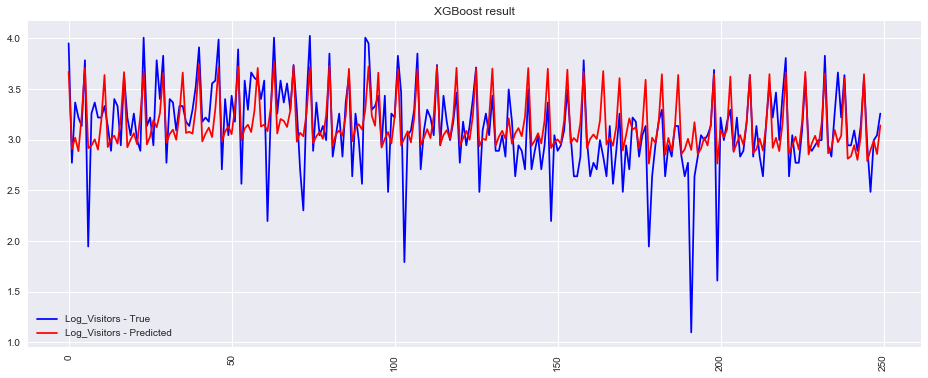

In [116]:
n_samples = 250
fig = plt.figure(figsize=(16,6))     

plt.plot(ytrue[:n_samples], c = 'blue',label='Log_Visitors - True')

plt.plot(ypred[:n_samples], c = 'red', label='Log_Visitors - Predicted')


plt.xticks(rotation=90)
#plt.xscale('log')
plt.title('XGBoost result')
plt.xlabel('')
plt.ylabel('')
#plt.ylim([-25e-6,25e-6])
plt.grid('on')
plt.legend()
plt.show()

## Meta Learning & Ensemble

In [96]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [97]:
ypred_xgb = Best_xgb.predict(valid[predictors])
ypred_lgb = Best_lgb.predict(valid[predictors])
ypred_ens = (ypred_xgb + ypred_lgb)/2  # Average Ensemble

In [98]:
ypred_xgb.shape,ypred_lgb.shape,ypred_ens.shape

((50422,), (50422,), (50422,))

In [99]:
feats=np.concatenate([ypred_lgb[:,None],ypred_xgb[:,None]],axis=1)
feats.shape

(50422, 2)

In [100]:
model.fit(feats,ytrue)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [101]:
ytrue= valid[target].values
ypred_meta = model.predict(feats)

In [103]:
#Results of Meta Learning
mae(ytrue,ypred_meta),rmse(ytrue,ypred_meta)

(0.3677818778278608, 0.4968229395276672)

In [104]:
#Results of average ensemble
mae(ytrue,ypred_ens),rmse(ytrue,ypred_ens)

(0.3678997861840608, 0.49701771417221813)

### Create and submit prediction

In [142]:
ypred_xgb = Best_xgb.predict(test[predictors])
ypred_lgb = Best_lgb.predict(test[predictors])
ypred_ens = (ypred_xgb + ypred_lgb)/2 

feats=np.concatenate([ypred_lgb[:,None],ypred_xgb[:,None]],axis=1)

In [106]:
ypred_meta = model.predict(feats)

In [143]:
preds = {'xgb':np.expm1(ypred_xgb),
         'lgb':np.expm1(ypred_lgb),
         'ens':np.expm1(ypred_ens),
         'meta':np.expm1(ypred_meta)}

In [144]:
for k,v in  preds.items(): 
    test['visitors']= v
    test[['id', 'visitors']].to_csv(f'./{k}_submission.csv', index=False, float_format='%.4f') 

In [ ]:
!kaggle competitions submit -c recruit-restaurant-visitor-forecasting -f xgboost_submission.csv -m "xgboost model"